# Hand-labelled Homography
Generate a pipeline for quantitative analysis of homography estimation. Do
 - Randomly sample sequences from list of videos
 - Safe sequences into folder
 - Annotate some sequences
 - Create evaluation pipeline, precision, drift


In [1]:
import sys
import pandas as pd
from dotmap import DotMap

sys.path.append('../')

from utils.io import load_yaml

server = 'local'
servers = load_yaml('../config/servers.yml')
server = DotMap(servers[server])

meta_df = pd.read_pickle('../config/cholec80_transforms.pkl')
meta_df

,database,train,file,pre_transforms,aug_transforms,auxiliary
0,cholec80,True,"{'name': 'video01.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
1,cholec80,True,"{'name': 'video02.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
2,cholec80,True,"{'name': 'video03.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
3,cholec80,True,"{'name': 'video04.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
4,cholec80,True,"{'name': 'video05.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
...,...,...,...,...,...,...
70,cholec80,True,"{'name': 'video17.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
71,cholec80,True,"{'name': 'video18.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
72,cholec80,True,"{'name': 'video19.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}
73,cholec80,True,"{'name': 'video20.mp4', 'path': 'videos'}","[{'module': 'utils.transforms', 'type': 'Crop'...","[{'module': 'torchvision.transforms', 'type': ...",{}


## Randomly Sample Image Sequences

In [ ]:
import cv2
import numpy as np
from kornia import tensor_to_image

from utils.transforms import anyDictListToCompose
from utils.sampling import RandomSequences
from utils.io import generate_path

debug = True

max_seq = 10
paths = meta_df.apply(lambda x: os.path.join(server.database.location, x.database, x.file['path'], x.file['name']), axis=1).tolist()
seq_len = 20
strides = [5]

# append to tensor transform, as meta_df is supposed to operate on tensors
to_tensor = {'module': 'torchvision.transforms', 'type': 'ToTensor', 'kwargs': {}}
transforms = meta_df.apply(lambda x: anyDictListToCompose([to_tensor] + x.pre_transforms), axis=1).tolist()

random_sequences = RandomSequences(
    max_seq=max_seq,
    paths=paths,
    seq_len=seq_len,
    strides=strides,
    transforms=transforms,
    verbose=True
)

out_prefix = 'out/homography_labelling'

for seq, vid_idx, frame_idx in random_sequences:
    print('vid_idx: {}, frame_idx: {}'.format(vid_idx, frame_idx))
    for idx, frame in enumerate(seq):
        frame = (tensor_to_image(frame)*255).astype(np.uint8)
        if debug:
            cv2.imshow('random_frame', frame)  # show images
            cv2.waitKey()
        else:
            vid_path = os.path.join(out_prefix, 'vid_{}_frame_{}'.format(vid_idx, frame_idx))
            generate_path(vid_path)
            cv2.imwrite(os.path.join(vid_path, 'frame_{}.png'.format(frame_idx + idx*strides[0])), frame)
cv2.destroyAllWindows()

### Dataset on Sampled Frames

In [7]:
import os

from utils.io import recursive_scan2df

prefix = 'out/homography_labelling'

# create a simplified dataframe
postfix = '.png'
df = recursive_scan2df(prefix, postfix)
df['vid'] = df.folder.apply(lambda x: int(x.split('_')[1]))
df['frame'] = df.file.apply(lambda x: int(x.split('_')[-1].replace(postfix, '')))
df = df.sort_values(['vid', 'frame']).reset_index(drop=True)

out_path = 'light_log'
df.to_pickle(os.path.join(prefix, out_path + '.pkl'))

df

,file,folder,vid,frame
0,frame_5980.png,vid_0_frame_5980,0,5980
1,frame_5985.png,vid_0_frame_5980,0,5985
2,frame_5990.png,vid_0_frame_5980,0,5990
3,frame_5995.png,vid_0_frame_5980,0,5995
4,frame_6000.png,vid_0_frame_5980,0,6000
...,...,...,...,...
335,frame_11041.png,vid_60_frame_10966,60,11041
336,frame_11046.png,vid_60_frame_10966,60,11046
337,frame_11051.png,vid_60_frame_10966,60,11051
338,frame_11056.png,vid_60_frame_10966,60,11056


## Estimate Homographies on Sequences
## Hand Labelled
### Tests

N Points: 7
vid_19_frame_0 sample_idx_66.txt


/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


N Points: 7
vid_18_frame_0 sample_idx_65.txt
N Points: 7
vid_16_frame_0 sample_idx_56.txt
N Points: 7
vid_0_frame_5980 pts.txt
N Points: 7
vid_15_frame_0 sample_idx_2.txt
N Points: 8
vid_6_frame_0 sample_idx_6.txt
N Points: 6
vid_12_frame_0 sample_idx_45.txt
N Points: 7
vid_13_frame_0 sample_idx_47.txt
N Points: 6
vid_5_frame_0 sample_idx_4.txt
N Points: 7
vid_11_frame_0 sample_idx_40.txt
N Points: 6
vid_4_frame_0 sample_idx_4.txt
N Points: 6
vid_36_frame_14944 pts.txt
N Points: 6
vid_8_frame_0 sample_idx_22.txt
N Points: 7
vid_1_frame_0 sample_idx_2.txt
N Points: 7
vid_17_frame_0 sample_idx_64.txt
N Points: 6
vid_14_frame_0 sample_idx_53.txt
N Points: 8
vid_58_frame_10791 pts.txt
N Points: 8
vid_7_frame_0 sample_idx_6.txt
N Points: 6
vid_10_frame_0 sample_idx_37.txt


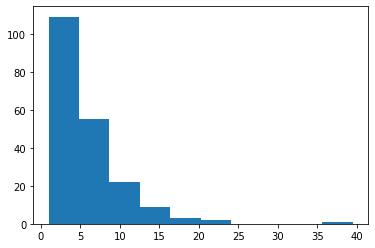

In [10]:
import pandas as pd
import numpy as np
import sys
import os
import cv2

sys.path.append('../')

from utils.io import recursive_scan2df
from utils.viz import yt_alpha_blend

def image_edges(shape):
    uv = np.array([
            [0           , 0           ],
            [0           , shape[1] - 1],
            [shape[0] - 1, shape[1] - 1],
            [shape[0] - 1, 0           ],
    ], dtype=np.float)
    return uv


prefix = 'out/homography_labelling'
vid_df = pd.read_pickle(os.path.join(prefix, 'light_log.pkl'))
pts_df = recursive_scan2df(prefix, '.txt')
mpds = []

for _, row in pts_df.iterrows():
    df = pd.read_csv(os.path.join(prefix, row.folder, row.file), delimiter='\t', header=None, names=['x', 'y']) # stored as x, y opencv convention
    n_img = len(vid_df[vid_df.folder == row.folder])
    n_pts = int(len(df) / n_img)

    print('N Points: {}'.format(n_pts))
    print(row.folder, row.file)
    
    # get homography
    for img_idx in range(n_img - 1):
        src_pts = df.iloc[img_idx*n_pts:(img_idx+1)*n_pts]
        dst_pts = df.iloc[(img_idx+1)*n_pts:(img_idx+2)*n_pts]
        
        src_pts = np.array([[pt.x, pt.y] for _, pt in src_pts.iterrows()])
        dst_pts = np.array([[pt.x, pt.y] for _, pt in dst_pts.iterrows()])

        H, _ = cv2.findHomography(src_pts, dst_pts)
        
        # show images
        img = cv2.imread(os.path.join(prefix, vid_df[vid_df.folder == row.folder].iloc[img_idx].folder, vid_df[vid_df.folder == row.folder].iloc[img_idx].file))
        wrp = cv2.imread(os.path.join(prefix, vid_df[vid_df.folder == row.folder].iloc[img_idx + 1].folder, vid_df[vid_df.folder == row.folder].iloc[img_idx + 1].file))
        cv2.imshow('img', img)
        cv2.imshow('wrp', wrp)

        # create blend
        wrp_pred = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))
        cv2.imshow('wrp_pred', wrp_pred)
        blend = yt_alpha_blend(wrp, wrp_pred)
        cv2.imshow('blend', blend/255)  # note that more points are needed, or blend will only work locally around pts
        cv2.waitKey()

        # duv analysis
        resize_shape = [240, 320]
        shape = img.shape

        scale = np.array([resize_shape[-2]/shape[0], resize_shape[-1]/shape[1]])

        src_pts *= scale
        dst_pts *= scale

        H, _ = cv2.findHomography(src_pts, dst_pts)

        edges = image_edges(resize_shape)
        edges = np.array(edges)
        wrp_edges = cv2.perspectiveTransform(edges.reshape(-1,1,2)[:,:,::-1], H)[:,:,::-1].squeeze()
        mpd = np.linalg.norm(edges - wrp_edges, axis=1).mean()
        mpds.append(mpd)

plt.hist(mpds)
plt.show()

cv2.destroyAllWindows()

### Mean-Pairwise-Distance Error on Hand-labelled Points

In [11]:
import cv2
import pandas as pd
import numpy as np
import os
import sys
import time
import torch
import torchvision
from kornia import tensor_to_image, image_to_tensor, warp_perspective
from torch.utils.data import DataLoader
from dotmap import DotMap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sys.path.append('../')

from datasets import ImageSequenceDataset
from utils.transforms import anyDictListToCompose
from utils.processing import FeatureHomographyEstimation, four_point_homography_to_matrix, image_edges
from utils.io import load_yaml, recursive_scan2df, generate_path
from utils.viz import yt_alpha_blend, draw_points
from lightning_modules import DeepImageHomographyEstimationModuleBackbone

server = 'local'
servers = load_yaml('../config/servers.yml')
server = DotMap(servers[server])

meta_df = pd.read_pickle('../config/cholec80_transforms.pkl')

show_image = True
save_figure = False
save_pdf = False
save_png = False
figure_prefix = 'out/homography_labelling/fig'
generate_path(figure_prefix)

# classical esimation
with_feature_estimation = False
fd = cv2.xfeatures2d.SURF_create()
# fd = cv2.ORB_create()
fh = FeatureHomographyEstimation(fd)

# deep estimation
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/ae_cai/resnet/34/version_0' #!!!!!!!!!
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/ae_cai/resnet/50/version_0' #!!!!!!!!
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/ae_cai/resnet/50/version_0'
prefix = '/home/martin/Tresors/homography_imitation_learning_logs/ae_cai/resnet/48/25/34/version_0'

configs = load_yaml(os.path.join(prefix, 'config.yml'))

# model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, 'checkpoints/epoch=49-step=94349.ckpt'), shape=configs['model']['shape']) #!!!!!!!!!!!!!
model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, 'checkpoints/epoch=99-step=47199.ckpt'), shape=configs['model']['shape'])

device = 'cpu'
if torch.cuda.is_available():
    print('Running with CUDA backend.')
    device = 'cuda'
# device = 'cpu' # for analysis

model.to(device)
model = model.eval()
model.freeze()

prefix = 'out/homography_labelling'
vid_df = pd.read_pickle(os.path.join(prefix, 'light_log.pkl'))
pts_df = recursive_scan2df(prefix, '.txt')

float_transform = torchvision.transforms.ConvertImageDtype(torch.float)

# errors
lobd_mpd = []  # to show how well transformation can be described via homography (lower bound)
none_mpd = []
deep_mpd = []
ft_mpd = []
deep_dt = []
ft_dt = []

lobd_df = pd.DataFrame(columns=['duv', 'duv_mpd'])
none_df = pd.DataFrame(columns=['duv', 'duv_mpd'])
deep_df = pd.DataFrame(columns=['duv', 'duv_mpd'])
ft_df = pd.DataFrame(columns=['duv', 'duv_mpd'])

for row_idx, row in pts_df.iterrows():
    df = pd.read_csv(os.path.join(prefix, row.folder, row.file), delimiter='\t', header=None, names=['x', 'y']) # stored as x, y opencv convention
    n_img = len(vid_df[vid_df.folder == row.folder])
    n_pts = int(len(df) / n_img)

    print('N Points: {}'.format(n_pts))
    
    # get homography
    for img_idx in range(n_img - 1):
        # load images
        img = cv2.imread(os.path.join(prefix, vid_df[vid_df.folder == row.folder].iloc[img_idx].folder, vid_df[vid_df.folder == row.folder].iloc[img_idx].file))
        wrp = cv2.imread(os.path.join(prefix, vid_df[vid_df.folder == row.folder].iloc[img_idx + 1].folder, vid_df[vid_df.folder == row.folder].iloc[img_idx + 1].file))

        resize_shape = configs['model']['shape']
        shape = img.shape

        scale = np.array([resize_shape[-2]/shape[0], resize_shape[-1]/shape[1]])

        src_pts = df.iloc[img_idx*n_pts:(img_idx+1)*n_pts]
        dst_pts = df.iloc[(img_idx+1)*n_pts:(img_idx+2)*n_pts]
        
        src_pts = np.array([[pt.x, pt.y] for _, pt in src_pts.iterrows()])
        dst_pts = np.array([[pt.x, pt.y] for _, pt in dst_pts.iterrows()])

        src_pts *= scale
        dst_pts *= scale

        H_lobd, _ = cv2.findHomography(src_pts, dst_pts)

        img, wrp = cv2.resize(img, (resize_shape[-1], resize_shape[-2])), cv2.resize(wrp, (resize_shape[-1], resize_shape[-2]))

        # configs['model']['shape']

        img, wrp = float_transform(image_to_tensor(img, keepdim=False)).to(device), float_transform(image_to_tensor(wrp, keepdim=False)).to(device)

        deep_start = time.time()
        duv = model(img, wrp)
        deep_dt.append(time.time() - deep_start)

        # deep prediction
        uv = image_edges(img)
        H_deep = four_point_homography_to_matrix(uv, duv)  # H: dst -> src
        H_deep_inv = torch.inverse(H_deep)
        H_deep_inv = H_deep_inv.cpu().numpy()

        # feature prediction
        img, wrp = (tensor_to_image(img)*255).astype(np.uint8), (tensor_to_image(wrp)*255).astype(np.uint8)
        ft_start = time.time()
        H_ft, duv_ft = fh(img, wrp)
        ft_dt.append(time.time() - ft_start)

        if H_ft is None:
            print('Skipping')
            continue

        dst_pts_deep = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H_deep_inv[0]).reshape(-1, 2)
        dst_pts_ft   = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H_ft).reshape(-1, 2)
        dst_pts_lobd = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H_lobd).reshape(-1, 2)

        dst_col = (255, 255, 0)
        dst_deep_col = (255, 0, 255)
        dst_ft_col = (0, 255, 255)

        wrp = draw_points(wrp, dst_pts, rad=3, col=dst_col)      # dst
        # wrp = draw_points(wrp, src_pts, rad=3, col=(0, 255, 255))     # src
        wrp = draw_points(wrp, dst_pts_deep, rad=3, col=dst_deep_col) # dst prediction deep
        wrp = draw_points(wrp, dst_pts_ft, rad=3, col=dst_ft_col)   # dst prediction feature

        # compute distance
        lobd_mpd.append(np.linalg.norm(dst_pts - dst_pts_lobd, axis=1).mean())
        none_mpd.append(np.linalg.norm(dst_pts - src_pts, axis=1).mean())
        deep_mpd.append(np.linalg.norm(dst_pts - dst_pts_deep, axis=1).mean())
        ft_mpd.append(np.linalg.norm(dst_pts - dst_pts_ft, axis=1).mean())

        # safe raw deviation
        lobd_df = lobd_df.append({'duv': dst_pts - dst_pts_lobd, 'duv_mpd': lobd_mpd[-1]}, ignore_index=True)
        none_df = none_df.append({'duv': dst_pts - src_pts, 'duv_mpd': none_mpd[-1]}, ignore_index=True)
        deep_df = deep_df.append({'duv': dst_pts - dst_pts_deep, 'duv_mpd': deep_mpd[-1]}, ignore_index=True)
        ft_df   = ft_df.append({'duv': dst_pts - dst_pts_ft, 'duv_mpd': ft_mpd[-1]}, ignore_index=True)

        if save_figure:
            figure = plt.figure()
            ax = figure.add_subplot(111)

            dst_patch = mpatches.Patch(color=tuple(ti/255 for ti in dst_col), label='Destination')
            dst_deep_patch = mpatches.Patch(color=tuple(ti/255 for ti in dst_deep_col), label='Deep')
            dst_ft_patch = mpatches.Patch(color=tuple(ti/255 for ti in dst_ft_col), label='Feature-based')
            ax.legend(handles=[dst_patch, dst_deep_patch, dst_ft_patch])
            plt.imshow(wrp[...,::-1])
            
            if save_pdf:
                plt.savefig(os.path.join(figure_prefix, 'labelled_dots_{}_{}.pdf'.format(row_idx, img_idx)))
            if save_png:
                plt.savefig(os.path.join(figure_prefix, 'labelled_dots_{}_{}.png'.format(row_idx, img_idx)), dpi=300)
        elif show_image: 
            cv2.putText(wrp, 'Desired', (10, 20), cv2.FONT_HERSHEY_PLAIN, 1.0, dst_col, 2)
            cv2.putText(wrp, 'Deep', (10, 40), cv2.FONT_HERSHEY_PLAIN, 1.0, dst_deep_col, 2)
            cv2.putText(wrp, 'Feature-based', (10, 60), cv2.FONT_HERSHEY_PLAIN, 1.0, dst_ft_col, 2)
            cv2.imshow('wrp', wrp)
            cv2.waitKey()

lobd_mpd = np.array(lobd_mpd)
none_mpd = np.array(none_mpd)
deep_mpd = np.array(deep_mpd)
ft_mpd = np.array(ft_mpd)
deep_dt = np.array(deep_dt)
ft_dt = np.array(ft_dt)

none_mpd_mean, none_mpd_std = none_mpd.mean(), none_mpd.std()
lobd_mpd_mean, lobd_mpd_std = lobd_mpd.mean(), lobd_mpd.std()
deep_mpd_mean, deep_mpd_std = deep_mpd.mean(), deep_mpd.std()
ft_mpd_mean, ft_mpd_std = ft_mpd.mean(), ft_mpd.std()
deep_dt_mean, deep_dt_std = deep_dt.mean(), deep_dt.std()
ft_dt_mean, ft_dt_std = ft_dt.mean(), ft_dt.std()

print('none: {:.2f} +/- {:.2f}'.format(none_mpd.mean(), none_mpd.std()))
print('lobd: {:.2f} +/- {:.2f}'.format(lobd_mpd.mean(), lobd_mpd.std()))
print('deep: {:.2f} +/- {:.2f}'.format(deep_mpd.mean(), deep_mpd.std()))
print('ft:   {:.2f} +/- {:.2f}'.format(ft_mpd.mean(), ft_mpd.std()))
print('deep_dt:   {:.2f} +/- {:.2f}'.format(deep_dt_mean*1.e3, deep_dt_std*1.e3))
print('ft_dt:   {:.2f} +/- {:.2f}'.format(ft_dt_mean*1.e3, ft_dt_std*1.e3))

cv2.destroyAllWindows()


Running with CUDA backend.
N Points: 7


IndexError: single positional indexer is out-of-bounds

In [ ]:
import os
import matplotlib.pyplot as plt
import sys

sys.path.append('../')

from utils.io import generate_path

labels = [
    'None',
    'Lower bound',
    'Deep: Resnet34',
    'Feature-based: SIFT'
]

means = [
    none_mpd_mean,
    lobd_mpd_mean,
    deep_mpd_mean,
    ft_mpd_mean
]

stds = [
    none_mpd_std,
    lobd_mpd_std,
    deep_mpd_std,
    ft_mpd_std
]

for idx, label in enumerate(labels):
    plt.errorbar(idx, means[idx], yerr=stds[idx], label=r'{} {:.2f}$\pm${:.2f} pixel'.format(label, means[idx], stds[idx]), fmt='o')

plt.legend()
plt.title('Hand-labelled Marker Error')
plt.ylabel('Mean Pairwise Distance / pixel')
plt.grid()
# plt.show()
prefix = 'out/homography_labelling/fig'
generate_path(prefix)
plt.savefig(os.path.join(prefix, 'hand_labelled_mean_pairwise_distance.pdf'))
plt.savefig(os.path.join(prefix, 'hand_labelled_mean_pairwise_distance.png'), dpi=300)

Identity - 2.36/3.44/4.33/7.60
ResNet-34 - 1.00/1.26/1.59/2.15
SURF & RANSAC - 1.09/1.48/2.07/3.53


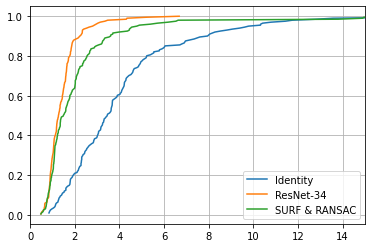

In [6]:
# duv_dfs = [lobd_df, none_df, deep_df, ft_df]
duv_dfs = [none_df, deep_df, ft_df]
# labels = ['lobd', 'none', 'deep', 'ft']
labels = ['Identity', 'ResNet-34', 'SURF & RANSAC']

for duv_df, label in zip(duv_dfs, labels):

    duv_df['duv_mpd'] = duv_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

    stats_df = duv_df.groupby('duv_mpd')['duv_mpd'].agg('count').pipe(pd.DataFrame).rename(columns = {'duv_mpd': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()

    th30 = stats_df[stats_df.cdf < 0.3].iloc[-1]
    th50 = stats_df[stats_df.cdf < 0.5].iloc[-1]
    th70 = stats_df[stats_df.cdf < 0.7].iloc[-1]
    th90 = stats_df[stats_df.cdf < 0.9].iloc[-1]

    print('{} - {:.2f}/{:.2f}/{:.2f}/{:.2f}'.format(label, th30.duv_mpd, th50.duv_mpd, th70.duv_mpd, th90.duv_mpd))

    # for stats_df, fd in zip(stats_dfs, fds):

    plt.plot(stats_df['duv_mpd'], stats_df['cdf'], label=label)
    plt.grid()
    plt.legend()
    plt.xlim([0, 15])

# plt.show()
plt.savefig('/media/martin/Samsung_T5/03_07_21_ae_cai_measurements/fig/frac/resnet34_48_25.pdf')

In [8]:
for duv_df, label in zip(duv_dfs, labels):
    duv_df.to_pickle('/media/martin/Samsung_T5/03_07_21_ae_cai_measurements/data/frac/{}.pkl'.format(label))

### Forward-Backward Consistency

In [ ]:
import cv2
import torch
import numpy as np
import pandas as pd
import torch.functional as F
from kornia import tensor_to_image, warp_perspective
from torch.utils.data import DataLoader
import sys
from dotmap import DotMap

sys.path.append('../')

from utils.viz import yt_alpha_blend
from utils.transforms import anyDictListToCompose
from utils.processing import forward_backward_sequence, image_edges, four_point_homography_to_matrix
from utils.io import load_yaml
from datasets import ImageSequenceDataset
from lightning_modules import DeepImageHomographyEstimationModuleBackbone

server = 'local'
servers = load_yaml('../config/servers.yml')
server = DotMap(servers[server])

meta_df = pd.read_pickle('../config/cholec80_transforms.pkl')


def visualize(fw_img, fw_wrp, bw_img, bw_wrp, fw_duv, bw_duv):
    fw_uv, bw_uv = image_edges(fw_img), image_edges(bw_img)
    fw_H, bw_H = four_point_homography_to_matrix(fw_uv, fw_duv), four_point_homography_to_matrix(bw_uv, bw_duv)

    fw_pred_wrp = warp_perspective(fw_img, torch.inverse(fw_H), fw_img.shape[-2:])
    bw_pred_wrp = warp_perspective(bw_img, torch.inverse(bw_H), bw_img.shape[-2:])
    
    fw_blend, bw_blend = yt_alpha_blend(fw_wrp, fw_pred_wrp), yt_alpha_blend(bw_wrp, bw_pred_wrp)
    fw_blend, bw_blend = tensor_to_image(fw_blend), tensor_to_image(bw_blend)

    cv2.imshow('fw_blend', fw_blend)
    cv2.imshow('bw_blend', bw_blend)
    cv2.waitKey()

prefix = 'out/homography_labelling'
# prefix = '/media/martin/Samsung_T5/data/endoscopic_data/camera_motion_separated_npy/without_camera_motion'
df = pd.read_pickle(os.path.join(prefix, 'light_log.pkl'))
# df = pd.read_pickle(os.path.join(prefix, 'light_log_without_camera_motion.pkl'))
seq_len = 2

transforms = [
    {'module': 'torchvision.transforms', 'type': 'ConvertImageDtype', 'kwargs': {'dtype': torch.float}}
]
transforms = [anyDictListToCompose(transforms) for _ in range(len(meta_df))]

ds = ImageSequenceDataset(
    df=df,
    prefix=prefix,
    seq_len=seq_len,
    transforms=transforms
)

# load network
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/deep_image_homography_estimation_backbone/version_2'
prefix = '/home/martin/Tresors/homography_imitation_learning_logs/deep_image_homography_estimation_backbone/version_10'
configs = load_yaml(os.path.join(prefix, 'config.yml'))
# model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, 'checkpoints/epoch=49.ckpt'), shape=configs['model']['shape'])
model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, 'checkpoints/epoch=53-step=47573.ckpt'), shape=configs['model']['shape'])

device = 'cpu'
if torch.cuda.is_available():
    print('Running with CUDA backend.')
    device = 'cuda'

model.to(device)
model = model.eval()
model.freeze()


batch_size = 1
num_workers = 0

dl = DataLoader(ds, batch_size=batch_size, num_workers=num_workers)

fw_mean_distance = []
bw_mean_distance = []
con_mean_distance = []

I = 100
for idx, batch in enumerate(dl):
    fw, bw = forward_backward_sequence(batch)

    # create pairs
    fw_img, fw_wrp = fw[:,:-1:].view((-1,) + fw.shape[-3:]).to(device), fw[:,1::].view((-1,) + fw.shape[-3:]).to(device) 
    bw_img, bw_wrp = bw[:,:-1:].view((-1,) + bw.shape[-3:]).to(device), bw[:,1::].view((-1,) + bw.shape[-3:]).to(device)

    # fw_img, fw_wrp, bw_img, bw_wrp = tensor_to_image(fw_img[0]), tensor_to_image(fw_wrp[0]), tensor_to_image(bw_img[0]), tensor_to_image(bw_wrp[0])
    # cv2.imshow('fw_img', fw_img)
    # cv2.imshow('fw_wrp', fw_wrp)
    # cv2.imshow('bw_img', bw_img)
    # cv2.imshow('bw_wrp', bw_wrp)
    # cv2.waitKey()

    fw_duv = model(fw_img, fw_wrp)
    bw_duv = model(bw_img, bw_wrp)

    # compute error, sum isnt that great of a measurement as 2*N vs N elements
    fw_mean_distance.append(torch.linalg.norm(fw_duv.sum(axis=0), axis=1).mean().item())
    bw_mean_distance.append(torch.linalg.norm(bw_duv.sum(axis=0), axis=1).mean().item())
    duv = torch.cat((fw_duv, bw_duv))
    con_mean_distance.append(torch.linalg.norm(duv.sum(axis=0), axis=1).mean().item())

    if idx == I - 1:
        break

    visualize(fw_img, fw_wrp, bw_img, bw_wrp, fw_duv, bw_duv)

fw_mean_distance = np.array(fw_mean_distance)
bw_mean_distance = np.array(bw_mean_distance)
con_mean_distance = np.array(con_mean_distance)

print(fw_mean_distance.mean(), fw_mean_distance.var())
print(bw_mean_distance.mean(), bw_mean_distance.var())
print(con_mean_distance.mean(), con_mean_distance.var())
    
cv2.destroyAllWindows()
